In [1]:
import tensorflow as tf
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential,Model,initializers,layers,Input
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

In [2]:
import tensorflow as tf
import numpy as np

(x_train,y_train),(x_test,y_test)=tf.keras.datasets.cifar10.load_data()

# Normalization
x_train=x_train/255.

x_test=x_test/255.

x_train.shape

x_train = tf.image.resize(x_train, [224,224]) 

x_test = tf.image.resize(x_test, [224,224]) 

y_train = tf.keras.utils.to_categorical(np.array(y_train))
y_test = tf.keras.utils.to_categorical(np.array(y_test))

KeyboardInterrupt: 

In [3]:
dir=r'D:\dataset\butterfly\train'
train_ds=tf.keras.preprocessing.image_dataset_from_directory(
dir,
labels="inferred",
label_mode="int",
class_names=None,
color_mode="rgb",
batch_size=4,
image_size=(224, 224),
shuffle=True,
seed=10,
validation_split=0.1,
subset='training',
interpolation="gaussian",
follow_links=False,
crop_to_aspect_ratio=False,)

validation_ds=tf.keras.preprocessing.image_dataset_from_directory(
dir,
validation_split=0.1,
subset='validation',
shuffle=True,
seed=10,
image_size=(224,224),
batch_size=4)

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255.)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

Found 1257 files belonging to 10 classes.
Using 1132 files for training.
Found 1257 files belonging to 10 classes.
Using 125 files for validation.


In [9]:
dir=r'D:\dataset\butterfly\train'
train_ds=tf.keras.preprocessing.image_dataset_from_directory(
dir,
labels="inferred",
label_mode="int",
class_names=None,
color_mode="rgb",
batch_size=4,
image_size=(224, 224),
shuffle=True,
seed=10,
validation_split=0.1,
subset='training',
interpolation="gaussian",
follow_links=False,
crop_to_aspect_ratio=False,)

validation_ds=tf.keras.preprocessing.image_dataset_from_directory(
dir,
validation_split=0.1,
subset='validation',
shuffle=True,
seed=10,
image_size=(224, 224),
batch_size=4)

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255.)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

Found 1257 files belonging to 10 classes.
Using 1132 files for training.
Found 1257 files belonging to 10 classes.
Using 125 files for validation.


In [4]:
with tf.device("/device:CPU:0"):
    model=Sequential([
        layers.Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),strides=(1,1),padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2D(kernel_size=(3,3),filters=64,strides=(1,1),padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),

        layers.Conv2D(filters=128,kernel_size=(3,3),strides=(1,1),padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2D(filters=128,kernel_size=(3,3),strides=(1,1),padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2D(filters=128,kernel_size=(3,3),strides=(1,1),padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),
    
        layers.Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),

        layers.Flatten(),
        layers.Dense(units=4096),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Dense(units=4096),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Dense(units=10,activation='softmax')
    ])

In [ ]:
plot_model(model,to_file='VGGnet_16.png',show_shapes=True)

In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization_18 (Bat  (None, 224, 224, 64)     256       
 chNormalization)                                                
                                                                 
 re_lu_18 (ReLU)             (None, 224, 224, 64)      0         
                                                                 
 conv2d_19 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization_19 (Bat  (None, 224, 224, 64)     256       
 chNormalization)                                                
                                                                 
 re_lu_19 (ReLU)             (None, 224, 224, 64)     

In [12]:
len(model.layers)

31

In [5]:
model_checkpoint_best_path=r'D:\GitHub_repo\CNN-Model-Application\save_weights\VGG16/'
model_checkpoint_best=ModelCheckpoint(filepath=model_checkpoint_best_path,monitor='val_acc',save_best_only=True,save_weights_only=True,save_freq='epoch')
early_stopping=EarlyStopping(monitor='val_acc',patience=30,min_delta=1e-4)


lr_rate=tf.keras.optimizers.schedules.ExponentialDecay(1e-3, 10000, 0.97, staircase=False, name=None)

    
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_rate),loss='sparse_categorical_crossentropy',metrics=['acc'])


In [6]:
with tf.device("/device:CPU:0"):
    history=model.fit(train_ds,validation_data=validation_ds,epochs=50,batch_size=4,verbose=1)

Epoch 1/50
283/283 [==============================] - 1105s 4s/step - loss: 3.6718 - acc: 0.2765 - val_loss: 4.8010 - val_acc: 0.4000
Epoch 2/50
283/283 [==============================] - 1169s 4s/step - loss: 2.6167 - acc: 0.4011 - val_loss: 16.5524 - val_acc: 0.3360
Epoch 3/50
283/283 [==============================] - 1107s 4s/step - loss: 2.2312 - acc: 0.4479 - val_loss: 5.2902 - val_acc: 0.5360
Epoch 4/50
283/283 [==============================] - 1104s 4s/step - loss: 1.9883 - acc: 0.5124 - val_loss: 1.0125 - val_acc: 0.7680
Epoch 5/50
283/283 [==============================] - 1144s 4s/step - loss: 1.5687 - acc: 0.5716 - val_loss: 2.6629 - val_acc: 0.6880
Epoch 6/50
283/283 [==============================] - 1097s 4s/step - loss: 1.5937 - acc: 0.5857 - val_loss: 0.6514 - val_acc: 0.8080
Epoch 7/50
283/283 [==============================] - 1083s 4s/step - loss: 1.5118 - acc: 0.6131 - val_loss: 0.8528 - val_acc: 0.7600
Epoch 8/50
283/283 [==============================] - 1080s 4

In [7]:
model.load_weights(model_checkpoint_best_path)
test_loss,test_acc=model.evaluate(x=x_test,y=y_test,verbose=1)

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for D:\GitHub_repo\CNN-Model-Application\save_weights\VGG16/

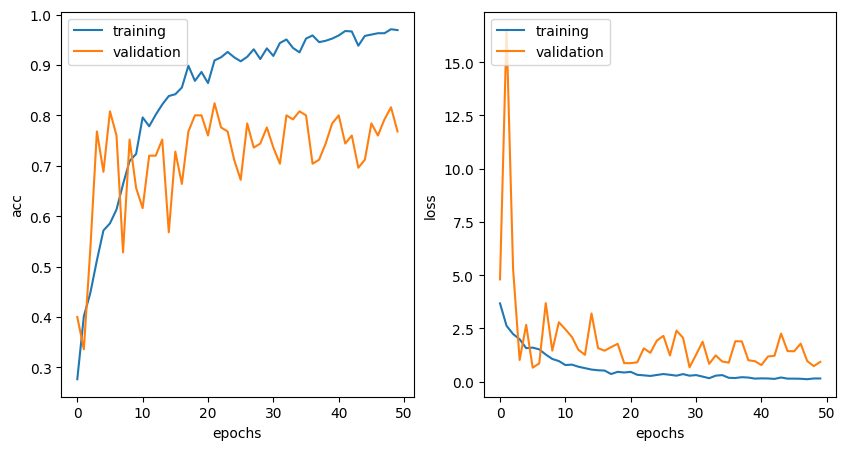

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(['training','validation'],loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['training','validation'],loc='upper left')

plt.show()